# Preprocess diverse population (and demographic) data sets into a harmonized grid time series

Aim to generate a population dataset that consistently covers the period from 1980 to present


Data sources

- GPWv4 is the main one and sits in the middle of the period of interest

In [18]:
%matplotlib inline

In [52]:
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import rasterio

import matplotlib.pyplot as plt

from config import POP_DATA_SRC, DATA_SRC, WEATHER_SRC


In [20]:
plt.rcParams['figure.dpi'] = 100

# ISIMIP population (histsoc)

Derived from HYDE project for ISIMIP collaboration

In [21]:
isimip_pop = xr.open_dataset(POP_DATA_SRC / 'population_histsoc_0p5deg_annual_1861-2005.nc', decode_times=False)
isimip_pop['time'] = isimip_pop['time'] + 1860
isimip_pop['time'] = isimip_pop['time'].astype(int)

In [22]:
isimip_pop

<xarray.Dataset>
Dimensions:     (lat: 360, lon: 720, time: 145)
Coordinates:
  * lon         (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat         (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * time        (time) int64 1861 1862 1863 1864 1865 ... 2002 2003 2004 2005
Data variables:
    population  (time, lat, lon) float32 ...
Attributes:
    Conventions:               CF-1.4
    nco_openmp_thread_number:  1
    project:                   isimip2b
    product:                   input
    dataset_type:              Population
    bias_correction:           None
    world_region:              Global land
    country:                   ALL
    time_frequency:            yr
    publisher:                 ISIMIP coordination team <info@isimip.org>
    description:               Population data set prepared for ISIMIP2b. Dat...
    doi:                       NA
    licence:                   CC BY 4.0
    creator:                   ISIMIP Coordi

## GPWv3

Add the GPWv3 files to the GPWv4 to extend back to 1990 from 2000 using a (hopefully) consistent dataset.

Use the 'ag' variants which are the UN WPP adjusted versions.

In [23]:
gpwv3_1990 = xr.open_rasterio(POP_DATA_SRC / 'gpwv3/gl_gpwv3_pcount_90_ascii_half/glp90ag30.asc')
gpwv3_1995 = xr.open_rasterio(POP_DATA_SRC / 'gpwv3/gl_gpwv3_pcount_95_ascii_half/glp95ag30.asc')

In [24]:
gpwv3_1990['band'] = [1990]
gpwv3_1990 = gpwv3_1990.rename({'band':'year',
                                'x':'longitude',
                                'y':'latitude'
                               })

gpwv3_1995['band'] = [1995]
gpwv3_1995 = gpwv3_1995.rename({'band':'year',
                                'x':'longitude',
                                'y':'latitude'
                               })

# GPWv4

In [25]:
dat = xr.open_dataarray(POP_DATA_SRC / 'gpwv4' / 'gpw_v4_une_atotpopbt_cntm_30_min.nc')
dat.name = 'population'
width = len(dat.longitude)

# Select only the 1st 5 rasters which correspond to the year counts
gpw_pop = dat.sel(raster=[1,2,3,4,5]).copy()

# turn the index into a year
gpw_pop['raster'] = 2000 + 5*(gpw_pop.raster-1)
gpw_pop = gpw_pop.rename({'raster':'year'})
gpw_pop['year'] = gpw_pop.year.astype(np.int32)



# Combine GPW 3 and 4

In [26]:
# Add 1990 and 1995 rasters
gpw_pop34 = xr.concat([gpwv3_1990, gpwv3_1995, gpw_pop], dim='year')
gpw_pop34.name = 'population'

# UN WPP 2019 (not gridded)

In [12]:
un_wpp_pop = pd.read_csv(POP_DATA_SRC / 'UN' / 'WPP2019_PopulationByAgeSex_Medium.csv')
#unit conversion
un_wpp_pop[['PopMale','PopFemale','PopTotal']] *= 1000
un_wpp_pop.head()

LocID     Location  VarID Variant  Time  MidPeriod AgeGrp  AgeGrpStart  \
0      4  Afghanistan      2  Medium  1950     1950.5    0-4            0   
1      4  Afghanistan      2  Medium  1950     1950.5    5-9            5   
2      4  Afghanistan      2  Medium  1950     1950.5  10-14           10   
3      4  Afghanistan      2  Medium  1950     1950.5  15-19           15   
4      4  Afghanistan      2  Medium  1950     1950.5  20-24           20   

   AgeGrpSpan   PopMale  PopFemale   PopTotal  
0           5  630044.0   661578.0  1291622.0  
1           5  516206.0   487335.0  1003540.0  
2           5  461378.0   423326.0   884704.0  
3           5  414369.0   369363.0   783732.0  
4           5  374109.0   318392.0   692501.0

In [11]:
un_pop_totals = un_wpp_pop[un_wpp_pop.LocID == 900].groupby('Time').PopTotal.sum()
un_pop_totals.head()

Time
1950    2.536431e+09
1951    2.584034e+09
1952    2.630862e+09
1953    2.677609e+09
1954    2.724847e+09
Name: PopTotal, dtype: float64

# Comparing population sources

In [12]:
isimip_pop_totals = isimip_pop.sel(time=slice(1950, None)).sum(dim=['lat','lon']).to_dataframe().population
gpw_pop_totals = gpw_pop34.sum(dim=['latitude','longitude']).to_dataframe().population

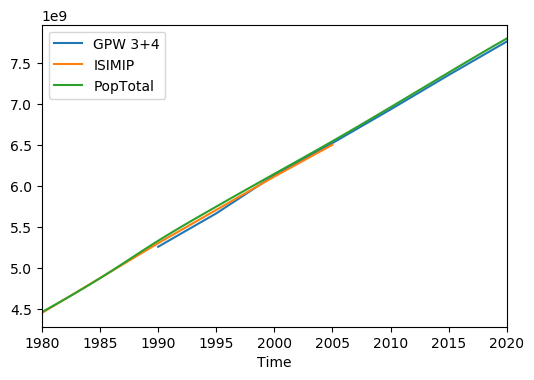

In [13]:
gpw_pop_totals.plot(label='GPW 3+4')
isimip_pop_totals.loc[1980:2020].plot(label='ISIMIP')
un_pop_totals.loc[1980:2020].plot()
plt.legend()

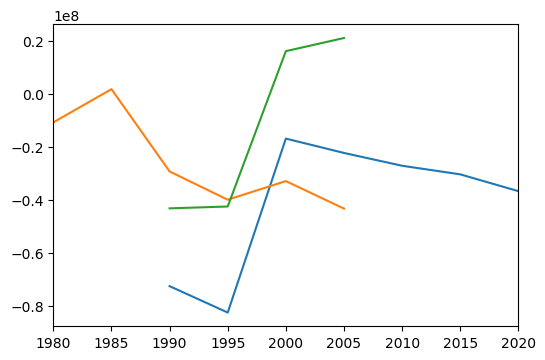

In [163]:
(gpw_pop_totals - un_pop_totals.loc[1980:2020:5]).plot()
(isimip_pop_totals.loc[1980:2020:5] - un_pop_totals.loc[1980:2020:5]).plot()
(gpw_pop_totals - isimip_pop_totals.loc[1980:2020:5]).plot()


Looks like a better continuity between ISIMIP and GPWv4 than between GPWv3 and GPWv4 - possibly because ISIMIP has better/newer cross checking. Next check the spatial differences

In [21]:
delta = isimip_pop.sel(time=2000).population.rename({'lat':'latitude','lon':'longitude'}) - gpw_pop.sel(year=2000).load()

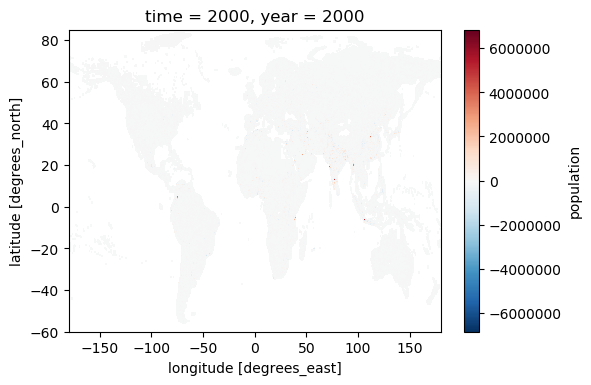

In [22]:
delta.plot()

In [28]:
delta_vals = delta.values.ravel()
delta_vals = delta_vals[np.isfinite(delta_vals)]

{'whiskers': [<matplotlib.lines.Line2D at 0x7fdbef7ba4e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdbef7bab70>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdbef7ba0b8>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdbef7baf98>],
 'fliers': [],
 'means': []}

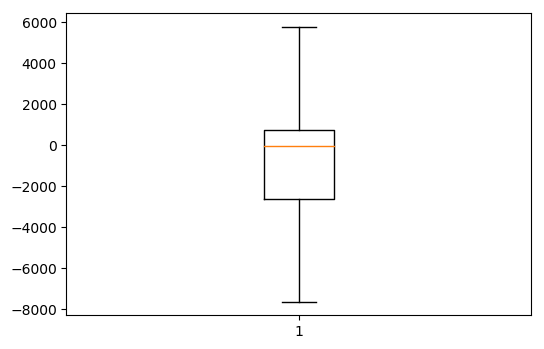

In [33]:
plt.boxplot(delta_vals, showfliers=False)
# plt.boxplot(delta_vals, showfliers=True)

In [32]:
isimip_pop

<xarray.Dataset>
Dimensions:     (lat: 360, lon: 720, time: 145)
Coordinates:
  * lon         (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat         (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * time        (time) int64 1861 1862 1863 1864 1865 ... 2002 2003 2004 2005
Data variables:
    population  (time, lat, lon) float32 ...
Attributes:
    Conventions:               CF-1.4
    nco_openmp_thread_number:  1
    project:                   isimip2b
    product:                   input
    dataset_type:              Population
    bias_correction:           None
    world_region:              Global land
    country:                   ALL
    time_frequency:            yr
    publisher:                 ISIMIP coordination team <info@isimip.org>
    description:               Population data set prepared for ISIMIP2b. Dat...
    doi:                       NA
    licence:                   CC BY 4.0
    creator:                   ISIMIP Coordi

# Conclusion

- Prefer ISIMIP over GPWv3 since its closer in totals to the UN WPP

Join ISIMIP and GPWv4 in 2000. Want to first interpolate GPWv4 to yearly for consistency.

In [13]:
pop = gpw_pop.interp(year=(np.arange(2000, 2021))).compute()

In [14]:
isimip_sel = isimip_pop.population.rename({'lat':'latitude','lon':'longitude', 'time':'year'}).sel(year=slice(None,1999))

In [15]:
pop = pop.reindex({'longitude': isimip_sel.longitude,
             'latitude': isimip_sel.latitude
            }
             )

In [16]:
pop = xr.concat([isimip_sel, pop], dim='year')

In [17]:
pop['year'] = pop.year.astype(np.int32)
pop.to_netcdf(POP_DATA_SRC / 'population_ismip_and_gpw4.nc')

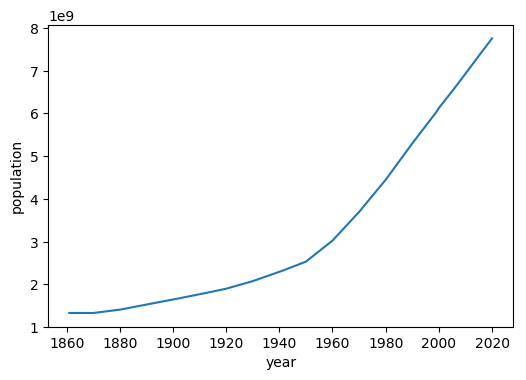

In [18]:
pop.sum(dim=['latitude','longitude']).plot()

### Compare the population at the changeover year

Want to check we don't get big spatial distribution changes at the join between datasets

> To account for yearly populaiton growth, compare the 'fraction of world population per cell' (i.e. normalise by total population)


Find that there are a handful of pixels with big changes but mostly it seems ok...


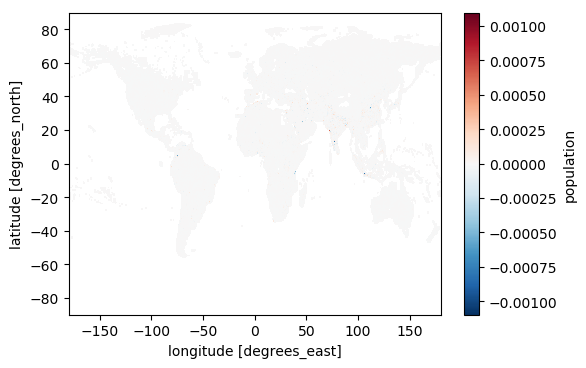

In [19]:
changeover_delta = ((pop.sel(year=2000) / pop.sel(year=2000).sum(dim=['latitude','longitude']))
                    - (pop.sel(year=1999))/ pop.sel(year=1999).sum(dim=['latitude','longitude']))
changeover_delta.plot()

In [44]:
# Save a copy for futher testing.
changeover_delta.to_netcdf('isimip_to_gpw_error.nc')

## Create a version of the population with shifted coordinates to match ERA5

Based on ERA documentation, the ERA points (at X.0 & X.5, Y.0 & Y.5) should strictly be consided point data but can be roughly interpreted as the centre of a pixel area.

~~For the population data there isn't clear documentation but inferring from the grid coords it seems the indexes refer to the top-left of the grid cells (at X.25 & X.75, Y.25 & Y.75). So to match with the centre of the ERA cells need to shift down and right by 0.25, then roll the whole dataset because ERA uses the convention of logitude from 0 to 360 (instead of -180 to 180).~~

=> NOTE according to [this](https://sedac.uservoice.com/knowledgebase/articles/41662-in-gpw-data-that-is-comprised-of-2-5-arc-min-cells ) the points DO reference cell centres and not corners. Also possible that ISIMIP and GPW are NOT following the same convention :( . A double check on ISIMP shows that actually it's fine and the grid starts at 89.75. Therefore we have a genuine grid mismatch. The ideal solution is to resample the weather data to match the population data but seriously, fuck that. On the other hand, might be more feasible to resample just before combining with population (so resample the heatwaves or whatever) since they will be much smaller, usually yearly or monthly values. A simpler approach is just to fudge it and adjust the population grid coords to correspond to a given weather coord. In this case probably best to revert to the original way of doing it so that its at least consistent over the years.


In [152]:
# Re-open the saved one, was having issues before...
pop_era = xr.open_dataarray(POP_DATA_SRC / 'population_ismip_and_gpw4.nc')
# pop_era['longitude'] += 0.25
# pop_era['latitude'] -= 0.25

In [153]:
pop_era = pop_era.roll(longitude=-360, roll_coords=False)

pop_era['longitude'] = np.arange(0, 360, 0.5)
pop_era['latitude'] += 0.25

In [147]:
# pop_era = pop_era.roll(longitude=-359, roll_coords=False)
# pop_era['longitude'] = np.arange(0, 360, 0.5)

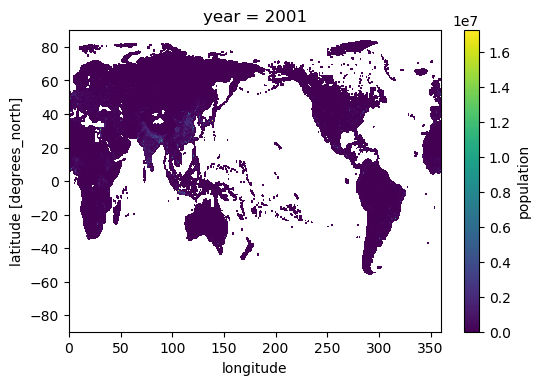

In [148]:
pop_era.sel(year=2001).plot()

In [150]:
pop_era.to_netcdf(POP_DATA_SRC / 'population_ismip_and_gpw4_era_compat.nc')

# Failed experiment: interpolate the population onto the ERA5 grid via population density

Idea is to convert area integral total pop into area density, which you treat as a point, then interpolate onto the new grid and convert back to the total population. However somethign wierd in the interpolation seems to cause the max population densities to drop a lot, and a small change in the mean population density. The reconstructed totals are fine but the big change in max density is a problem and I don't llike it. Just stick to re-aligning the coordinates

In [37]:
pop = xr.open_dataarray(POP_DATA_SRC / 'population_ismip_and_gpw4.nc')

In [116]:
def area_of_pixel(pixel_size, center_lat):
    """Calculate m^2 area of a wgs84 square pixel.

    Adapted from: https://gis.stackexchange.com/a/127327/2397

    Parameters:
        pixel_size (float): length of side of pixel in degrees.
        center_lat (float): latitude of the center of the pixel. Note this
            value +/- half the `pixel-size` must not exceed 90/-90 degrees
            latitude or an invalid area will be calculated.

    Returns:
        Area of square pixel of side length `pixel_size` centered at
        `center_lat` in m^2.

    """
    a = 6378137  # meters
    b = 6356752.3142  # meters
    e = np.sqrt(1 - (b/a)**2)
    area_list = []
    for f in [center_lat + pixel_size/2, center_lat - pixel_size/2]:
        zm = 1 - e*np.sin(np.radians(f))
        zp = 1 + e*np.sin(np.radians(f))
        area = (np.pi * b**2 * (
                np.log(zp/zm) / (2*e) +
                np.sin(np.radians(f)) / (zp*zm)))
        
        area_list.append(area)
    return (pixel_size / 360.) * (area_list[0] - area_list[1])

In [117]:
# areas of pixels in km2
areas = area_of_pixel(0.5, pop.latitude) / 1000000

In [119]:
pop_dens = pop.fillna(0) / areas

In [54]:
MIN_TEMPERATURES_FOLDER = WEATHER_SRC / 'era5' / 'daily_temperature_summary'

t_min = xr.open_dataset(sorted(list(MIN_TEMPERATURES_FOLDER.glob('*.nc')))[-1]).t_min

In [75]:
pop_dens = pop_dens.roll(longitude=-360, roll_coords=False)
pop_dens['longitude'] = np.arange(0.25, 360, 0.5)

In [120]:
pop_dens_interp = pop_dens.interp_like(t_min.isel(time=0, drop=True), method='linear')

In [121]:
pop_dens_interp.max()

<xarray.DataArray ()>
array(3510.883188)

In [109]:
pop_dens.max()

<xarray.DataArray ()>
array(7747.21927)

In [128]:
pop_reconstructed =  pop_dens_interp * (area_of_pixel(0.5, pop_dens_interp.latitude) / 1000000)

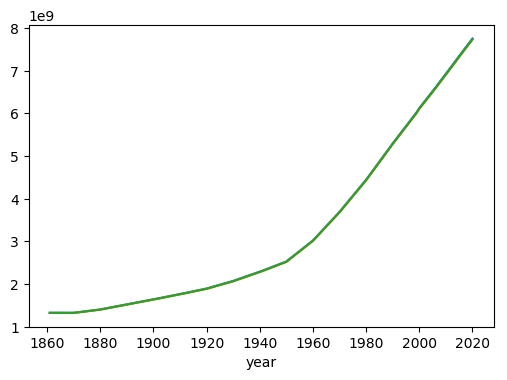

In [129]:
pop.sum(dim=['latitude','longitude']).plot()
pop_interp.sum(dim=['latitude','longitude']).plot()
pop_reconstructed.sum(dim=['latitude','longitude']).plot()

In [130]:
pop_reconstructed.max()

<xarray.DataArray ()>
array(9965397.036301)

In [131]:
pop.max()

<xarray.DataArray 'population' ()>
array(23065668.)